In [1]:
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels
from independent_set_solver import solve_max_independent_set_integer
from scipy.sparse import lil_matrix
from tqdm import tqdm

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
eps_sample = -0.05
world_name = "cheese102.instance.json"#small_polys[1] #"cheese205.instance.json"#fpg-poly_0000000060_h1.instance.json"#"srpg_iso_aligned_mc0000172.instance.json"##"fpg-poly_0000000070_h1.instance.json"
world = World("./data/evalexamples/"+world_name)
world.build_offset_cfree(eps_sample)

def sample_cfree_handle(n, m, regions=None):
	points = np.zeros((n,2))
	if regions is None: regions = []		
	for i in range(n):
		bt_tries = 0
		while bt_tries<m:
			point = world.sample_cfree_distance(1, eps = eps_sample)[0]
			#point = world.sample_cfree(1)[0]
			if point_near_regions(point, regions, tries = 100, eps = 0.1):
				bt_tries+=1
			else:
				break
		if bt_tries == m:
			return points, True
		
		points[i] = point
	return points, False

def vgraph_builder(points, regions, region_vis_obstacles=True):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			if region_vis_obstacles:
				if vis_reg(point, other, world, regions):
					adj_mat[i,j] = adj_mat[j,i] = 1
			else:
				if vis_reg(point, other, world, []):
					adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat.toarray()




In [3]:
import numpy as np
from pydrake.all import (MathematicalProgram, SolverOptions, 
			            Solve, CommonSolverOption)

def compute_minimum_clique_partition(adj_mat):
    prog = MathematicalProgram()
    n = adj_mat.shape[0]
    adj_compl = 1- adj_mat
    np.fill_diagonal(adj_compl, 0)
    max_num_colors = 44 #n/10
    #color variables
    x = prog.NewBinaryVariables(n,max_num_colors)
    #indexvariables for the color
    w = prog.NewBinaryVariables(max_num_colors)
    #one color per vertex
    for i in range(n):
        prog.AddLinearConstraint(np.sum(x[i, :])==1)

    for c in range(max_num_colors):
        for i in range(0,n):
                for j in range(i,n):
                    if adj_compl[i,j]:
                        prog.AddLinearConstraint(x[i, c] + x[j, c] <= w[c])

    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)
    prog.AddLinearCost(np.sum(w))
    result = Solve(prog, solver_options=solver_options)
    clique_colors = np.where(result.GetSolution(w) == 1)[0]
    cliques = []
    xsol = result.GetSolution(x)
    for col in clique_colors:
        cliques.append(np.where(xsol[:,col] ==1)[0])
    return result.get_optimal_cost(), cliques

def greedy_clique_partition(adj_mat):
    n = len(adj_mat)
    result = [-1] * n
    adj_compl = 1- adj_mat
    np.fill_diagonal(adj_compl, 0)

    # Sort the vertices based on their degree (number of connections)
    sorted_vertices = sorted(range(n), key=lambda x: sum(adj_mat[x]), reverse=True)

    # Assign the smallest available color to each vertex
    for vertex in sorted_vertices:
        available_colors = set(range(n))
        for neighbor in range(n):
            if adj_compl[vertex, neighbor] == 1 and result[neighbor] in available_colors:
                available_colors.remove(result[neighbor])
        result[vertex] = min(available_colors)

    # Calculate the chromatic number
    nr_cliques = max(result) + 1
    result = np.array(result)
    cliques =[]
    for i in range(nr_cliques):
        cliques.append(np.where(result == i)[0])
    return nr_cliques, cliques

In [4]:
N = 50
pts, _ = sample_cfree_handle(N, 3000,[])
adj_mat = vgraph_builder(pts, [], True)
val, ind_set_idx_tuple  = solve_max_independent_set_integer(adj_mat=adj_mat)
ind_set_idx = ind_set_idx_tuple[0]
kernels = compute_kernels(ind_set_idx, adj_mat)
#nr_cliques, cliques = compute_minimum_clique_partition(adj_mat)
nr_cliques, cliques = greedy_clique_partition(adj_mat)
print(nr_cliques)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 95.09it/s] 

15


In [5]:
from pydrake.all import VPolytope, HPolyhedron
from scipy.spatial import ConvexHull

seed_polys = []
for c in cliques:
    if len(c)>= 3:
        pts_clique = pts[c,:]
        hull = ConvexHull(pts_clique)
        hull_vertices = pts_clique[hull.vertices, :]
        seed_polys.append(VPolytope(hull_vertices.T))
    else:
        seed_polys.append(None)

In [7]:
from ellipse_utils import get_lj_ellipse, plot_ellipse
seed_ellipses = []
for c in cliques:
    pts_c =  pts[c, :]
    HE, _, _ = get_lj_ellipse(pts_c)
    seed_ellipses.append(HE)

In [8]:
seed_ellipses

 None,
 None,
 None,

In [10]:
cliques

[array([ 0, 11, 12, 19, 21, 23, 30, 33, 40]),
 array([17, 24, 28, 37, 41, 43, 49]),
 array([ 3, 22, 25, 38, 44, 46]),
 array([ 1,  7, 14, 15, 45]),
 array([ 9, 18, 27, 47]),
 array([ 4, 13, 48]),
 array([29, 42]),
 array([ 2,  8, 10]),
 array([16, 20]),
 array([32, 34]),
 array([35]),
 array([ 5, 26, 36]),
 array([39]),
 array([6]),
 array([31])]

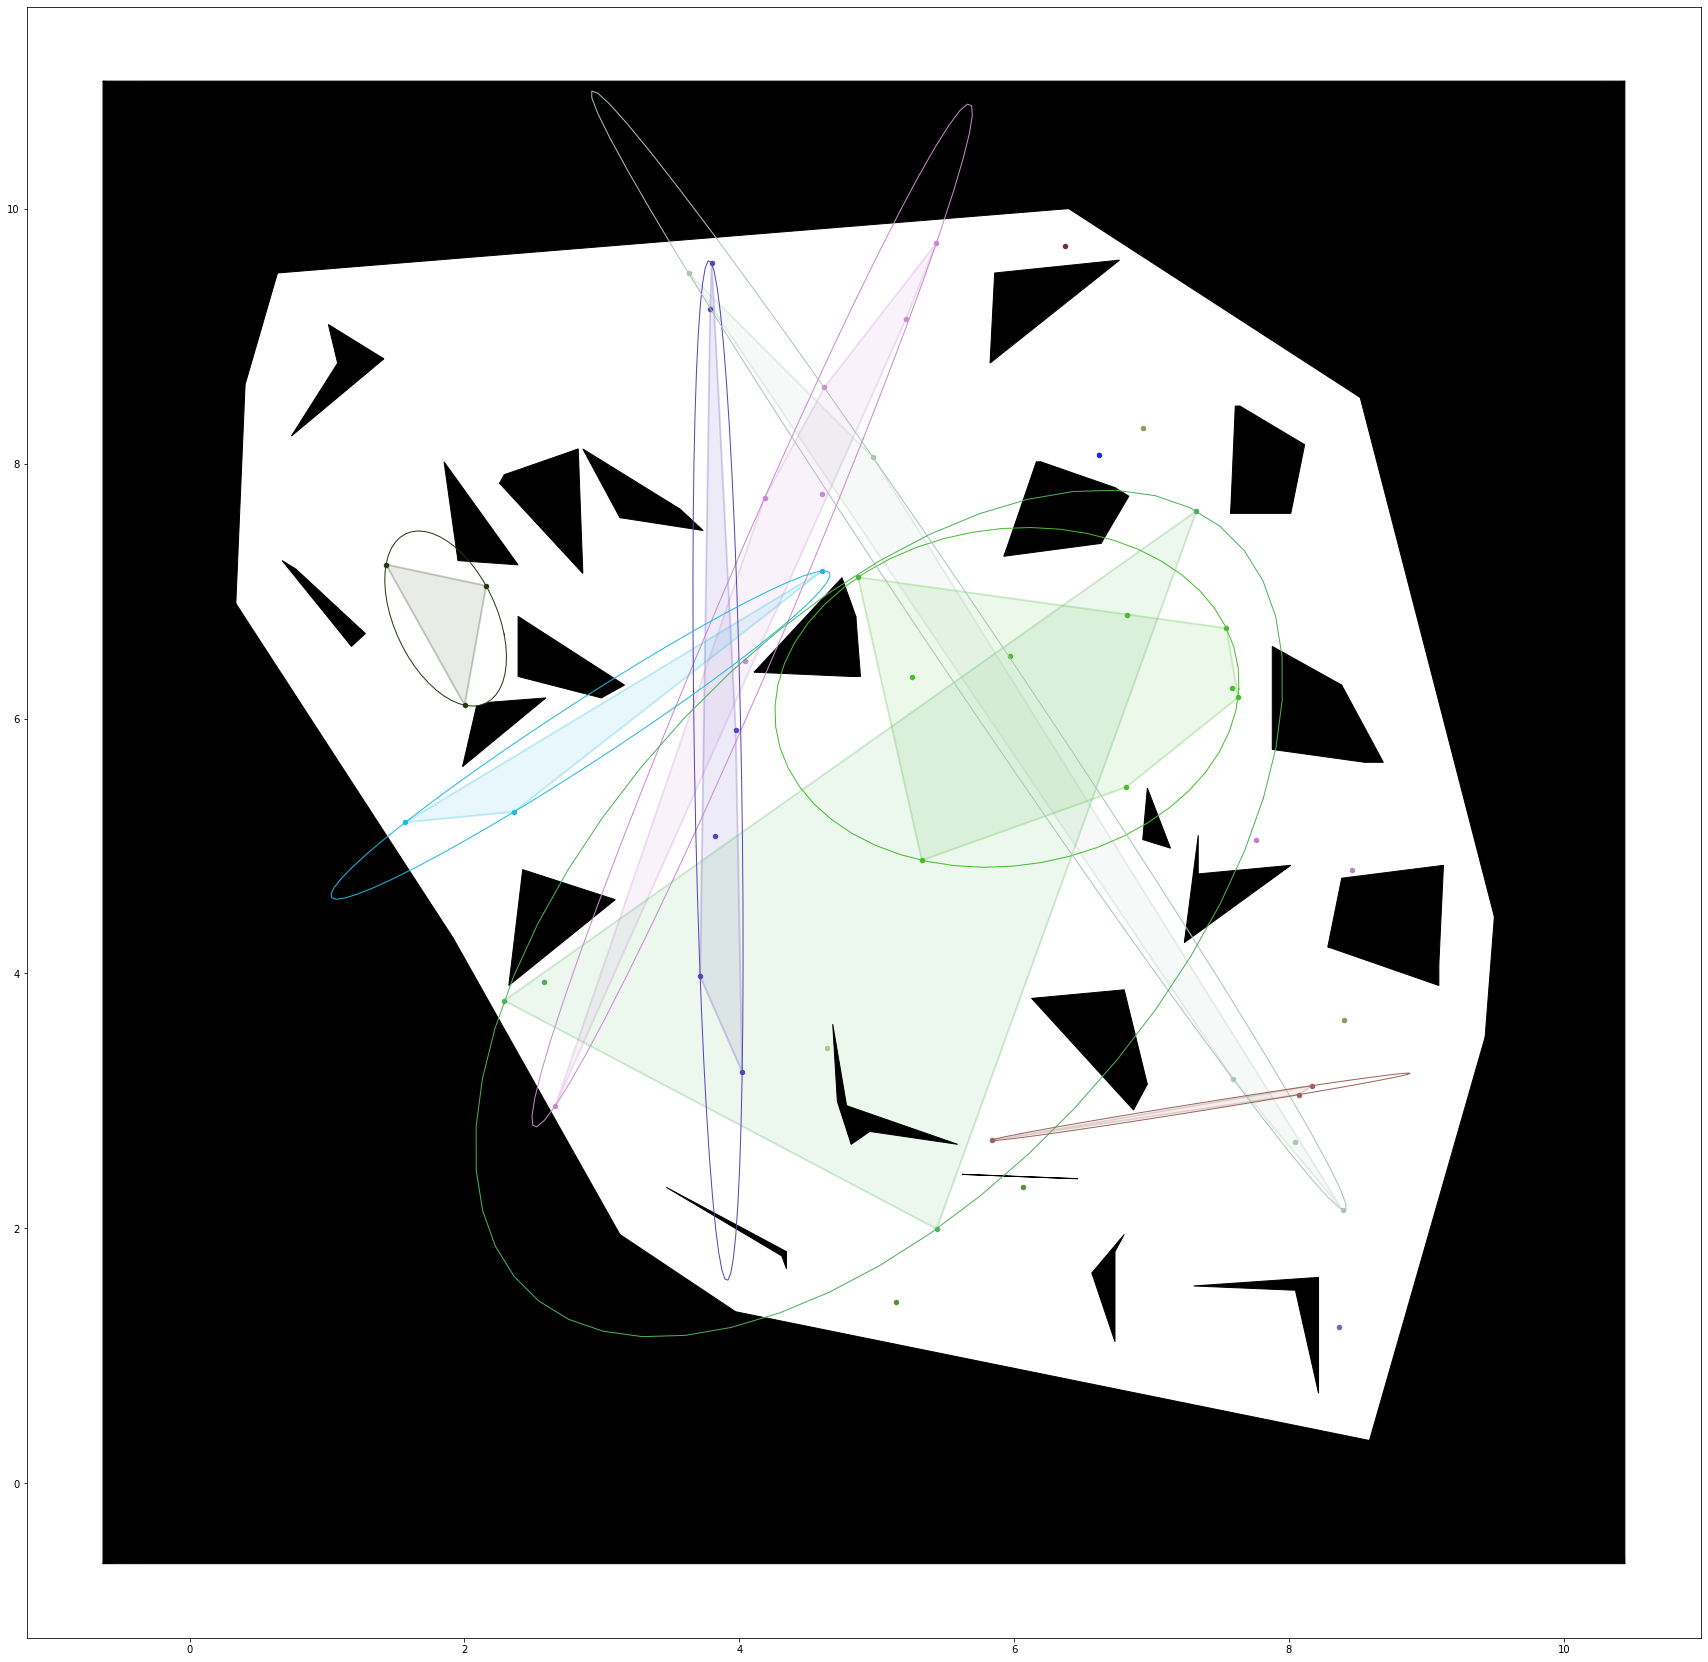

In [9]:
from utils import generate_random_colors
from seeding_utils import sorted_vertices
fig,ax = plt.subplots(figsize = (30,30))
ax.scatter(pts[:, 0], pts[:,1], c = 'k', s = 5)
#ax.scatter(pts[ind_set_idx, 0], pts[ind_set_idx,1], c = 'r', s = 10, zorder = 10)
# for k in kernels:
#     ax.scatter(pts[k, 0], pts[k, 1], s = 200)

colors = generate_random_colors(len(cliques))
for idx, c in enumerate(cliques):
    colc = colors[idx]
    seed_pol = seed_polys[idx]
    seed_ell = seed_ellipses[idx]
    scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 20, color = colc)
    #add edges from the center of each clique
    center = c[0]
    # for ci in c[1:]:
    #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

    if seed_pol is not None:    
        v = sorted_vertices(seed_pol).T#s
        v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
        p = ax.plot(v[:,0], v[:,1], linewidth = 2, alpha = 0.2, c = colc, zorder = 0)

        ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)
    if seed_ell is not None:plot_ellipse(ax, seed_ell, 50, color = colc)
world.plot_cfree(ax)

In [9]:
seed_ellipses

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]